# Introduction
In this notebook, we anaylze our state dataset to look for name trends. 

In [1]:
#Import Libraries
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import mplcursors
import plotly.express as px
import altair as alt

from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE

import ipywidgets as widgets
from IPython.display import display, HTML

import dash
from dash import dcc, html
from dash.dependencies import Input, Output

import warnings
warnings.filterwarnings('ignore')

## Load Data

In [2]:
#Load national data from SSA
national_df = pd.read_csv("Data/national_data.csv")
#Load state data from SSA
states_df = pd.read_csv("Data/states_data.csv")

In [34]:
#Look at state Names per Year
states_df.head(10)

,state,sex,year,name,count,region
0,AK,F,1910,Mary,14,West
1,AK,F,1910,Annie,12,West
2,AK,F,1910,Anna,10,West
3,AK,F,1910,Margaret,8,West
4,AK,F,1910,Helen,7,West
5,AK,F,1910,Elsie,6,West
6,AK,F,1910,Lucy,6,West
7,AK,F,1910,Dorothy,5,West
8,AK,F,1911,Mary,12,West
9,AK,F,1911,Margaret,7,West


In [35]:
# Create a dropdown widget for selecting the year
year_selector = widgets.Dropdown(
    options=sorted(states_df['year'].unique()),
    description='Select Year:',
    disabled=False
)

# Define a function to update the plots based on the selected year
def update_plots(year):
    # Filter the DataFrame based on the selected year
    filtered_df = states_df[states_df['year'] == year]
    
    # Filter out only the data for male and female separately
    male_df = filtered_df[filtered_df['sex'] == 'M']
    female_df = filtered_df[filtered_df['sex'] == 'F']
    
    # Group by State and Name and sum the counts
    top_male_names = male_df.groupby(['state', 'name'])['count'].sum().reset_index()
    top_female_names = female_df.groupby(['state', 'name'])['count'].sum().reset_index()
    
    # Get top male and female names for each state
    top_male_names = top_male_names.loc[top_male_names.groupby('state')['count'].idxmax()]
    top_female_names = top_female_names.loc[top_female_names.groupby('state')['count'].idxmax()]
    
    # Plot the top male names
    fig_male = px.bar(top_male_names, x='state', y='count', color='name', title='Top Male Names by State')
    
    # Plot the top female names
    fig_female = px.bar(top_female_names, x='state', y='count', color='name', title='Top Female Names by State')
    
    # Show the plots
    display(fig_male)
    display(fig_female)

# Call the update_plots function when the value of the dropdown changes
widgets.interactive(update_plots, year=year_selector)

interactive(children=(Dropdown(description='Select Year:', options=(1910, 1911, 1912, 1913, 1914, 1915, 1916, …

### Most Popular Name by State Over Time

In [36]:
def process_and_plot_data(df, sex):
    # Filter dataframe by sex
    filtered_df = df[df['sex'] == sex]
    
    # Group by Year, State, and Name, and Sum Count
    top_names_per_year_state = filtered_df.groupby(['year', 'state', 'name'])['count'].sum().reset_index()
    # Sort values
    top_names_per_year_state = top_names_per_year_state.sort_values(by=['year', 'state', 'count'], ascending=False)
    # Get top name for each year
    top_names_per_year_state = top_names_per_year_state.groupby(['year', 'state']).first().reset_index()

    # Plotly choropleth map
    fig = px.choropleth(locations=top_names_per_year_state['state'],
                        locationmode="USA-states",
                        color=top_names_per_year_state['name'],
                        scope="usa",
                        animation_frame=top_names_per_year_state['year'],
                        title=f"Top {sex} Baby Name by State and Year",
                        labels={'color': f'Top {sex} name'},
                        hover_name=top_names_per_year_state['name'],
                        color_continuous_scale=px.colors.sequential.Plasma)


    fig.update_layout(geo=dict(bgcolor='rgba(0,0,0,0)',
                               lakecolor='rgba(0,0,0,0)'))

    fig.show()

In [37]:
# Plot most popular male name in US by state over time
process_and_plot_data(states_df, 'M')  # for male

In [10]:
# Plot most popular female name in US by state over time
process_and_plot_data(states_df, 'F')  # for female

### Get Top Names for Specific Year

In [15]:
def plot_top_names(year, sex, state=None):
    """
    Plot the top 10 names for a given year and sex, optionally filtered by state.

    Parameters:
        year (int): Year for which to plot the top names.
        sex (str): Sex for which to plot the top names ('M' or 'F').
        state (str or None): State abbreviation to filter the data, or None to include all states. Default is None.
    """
    # Define custom color palette for 'M' and 'F'
    colors = {'M': '#000080',  # Navy Blue for 'M'
              'F': '#FF69B4'}  # Hot Pink for 'F'

    # Filter for the given year, sex, and optionally state
    if state:
        filtered_data = states_df[(states_df['year'] == year) & (states_df['sex'] == sex) & (states_df['state'] == state)]
    else:
        filtered_data = states_df[(states_df['year'] == year) & (states_df['sex'] == sex)]
    
    # Group by name and sum the counts
    top_names = filtered_data.groupby('name')['count'].sum().nlargest(10)
    
    # Plotting top names with custom colors based on sex
    plt.figure(figsize=(10, 6))
    top_names.plot(kind='bar', color=[colors[sex]] * 10)
    plt.title(f'Top 10 {sex.capitalize()} Names in {year}' + (f', {state}' if state else ''))
    plt.xlabel('Name')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

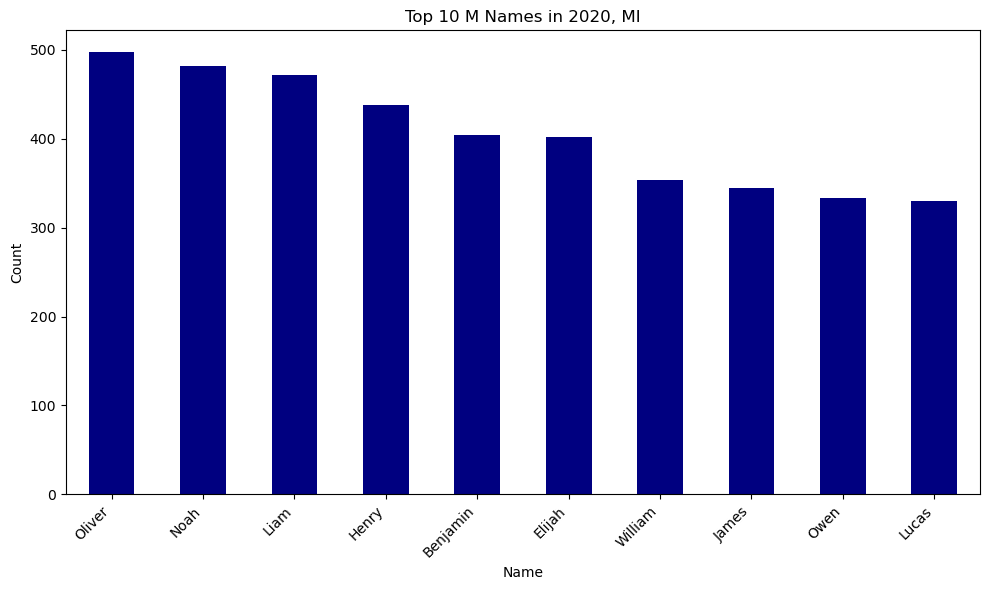

In [18]:
plot_top_names(2020, 'M', state='MI')  # Plot top male names in 2020

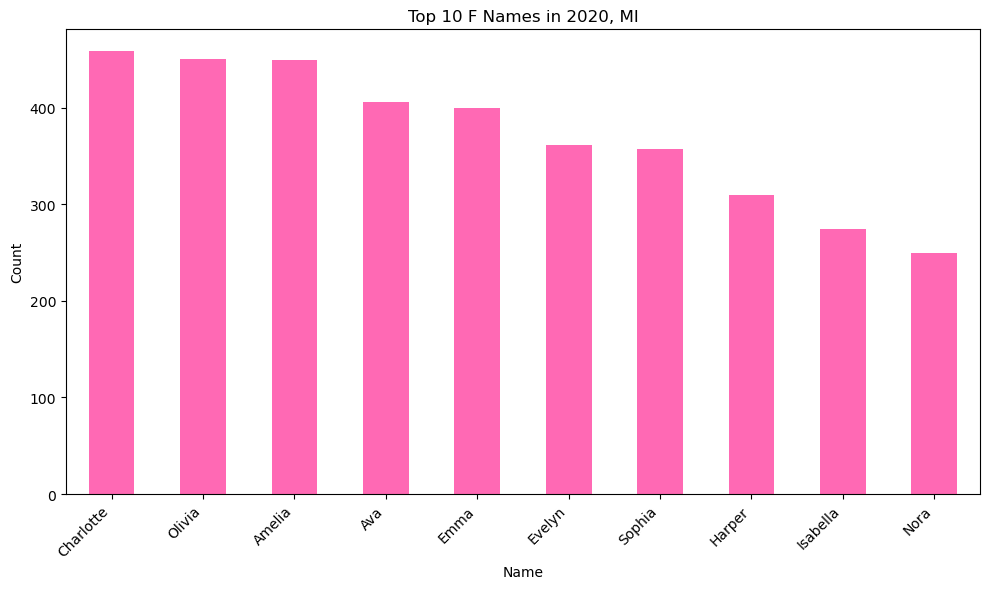

In [19]:
plot_top_names(2020, 'F', state='MI')  # Plot top female names in 2020

### Regional Name Preferences

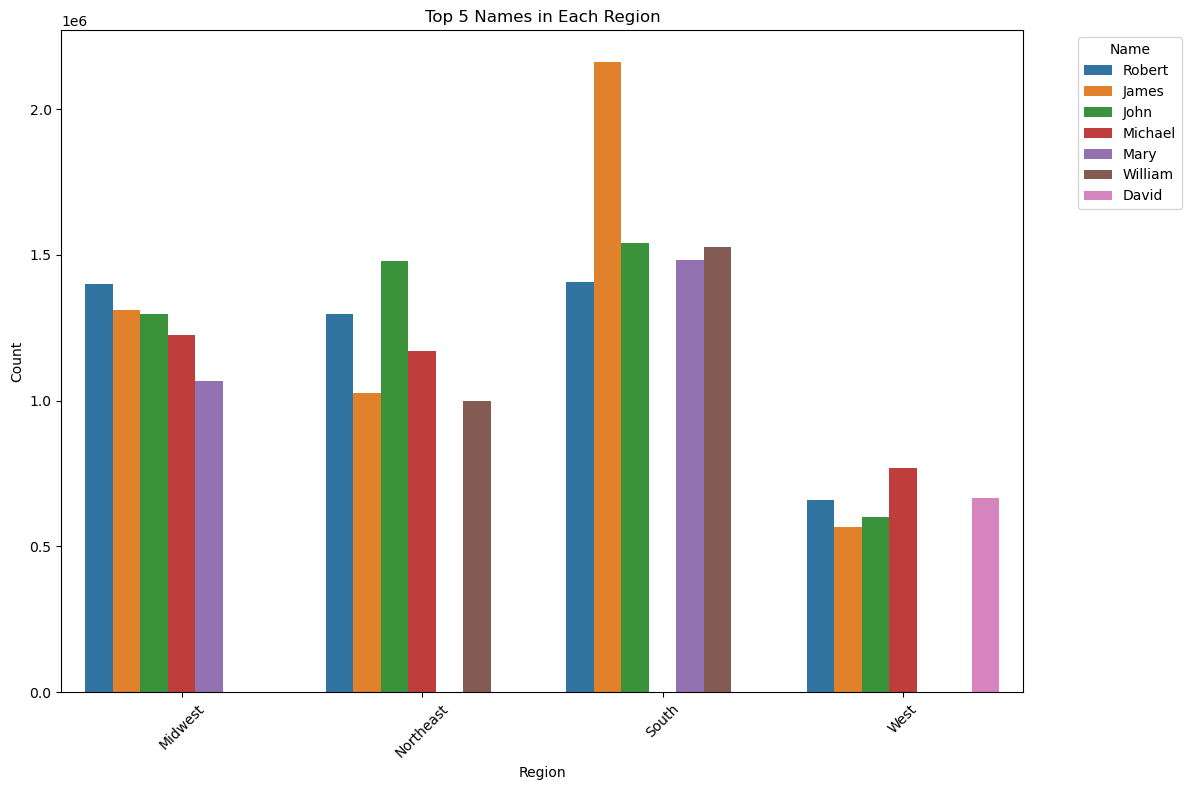

In [20]:
# Group by region and name to get the total counts of each name in each region
region_name_counts = states_df.groupby(['region', 'name'])['count'].sum().reset_index()

# Filter to get top names in each region (you can adjust the number of top names as needed)
top_names_per_region = region_name_counts.groupby('region').apply(lambda x: x.nlargest(5, 'count'))

# Create a grouped bar chart
plt.figure(figsize=(12, 8))
sns.barplot(data=top_names_per_region, x='region', y='count', hue='name')
plt.title('Top 5 Names in Each Region')
plt.xlabel('Region')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()